[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/amgp-upm/dl_course_chile/blob/main/3_FeedforwardNeural.ipynb)

In [35]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import SubsetRandomSampler

try:
    from torchinfo import summary
except ImportError:
    ! pip install torchinfo
    from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from sklearn.metrics import classification_report

### Descarga del dataset

In [37]:
train_dataset = datasets.MNIST(root='./data', train=True, 
                               transform=transforms.ToTensor(), download=True)

test_dataset = datasets.MNIST(root='./data', train=False, 
                              transform=transforms.ToTensor())

### Visualización de un ejemplo de un ejemplo

# Train images: 60000
# Test images: 10000


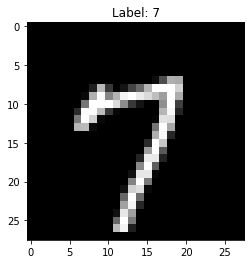

In [38]:
num_train_images = len(train_dataset)
num_test_images = len(test_dataset)

print(f'# Train images: {num_train_images}')
print(f'# Test images: {num_test_images}')

idx = np.random.choice(range(num_train_images))

image = train_dataset[idx][0]
label = train_dataset[idx][1]

plt.imshow(np.squeeze(image.numpy()), cmap='gray')
plt.title(f'Label: {label}')
plt.show()

### Dataloader

El DataLoader es una herramienta importante para preparar, gestionar y servir los datos a las redes de aprendizaje profundo. 

In [51]:
batch_size = 100
num_epochs = 100
run_dry = False # Si True solamente utiliza una pequeña parte del conjunto de datos.

if run_dry:
    train_sampler = SubsetRandomSampler(range(len(train_dataset))[:batch_size * 2])
    test_sampler = SubsetRandomSampler(range(len(test_dataset))[:batch_size * 2])
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                              batch_size=batch_size, 
                                              sampler=train_sampler)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                              batch_size=batch_size, 
                                              shuffle=False, 
                                              sampler=test_sampler
                                              )
else:
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                              batch_size=batch_size, 
                                               shuffle=True) 

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                              batch_size=batch_size, 
                                              shuffle=False
                                              )

### Visualización de ejemplos aleatorios de un batch

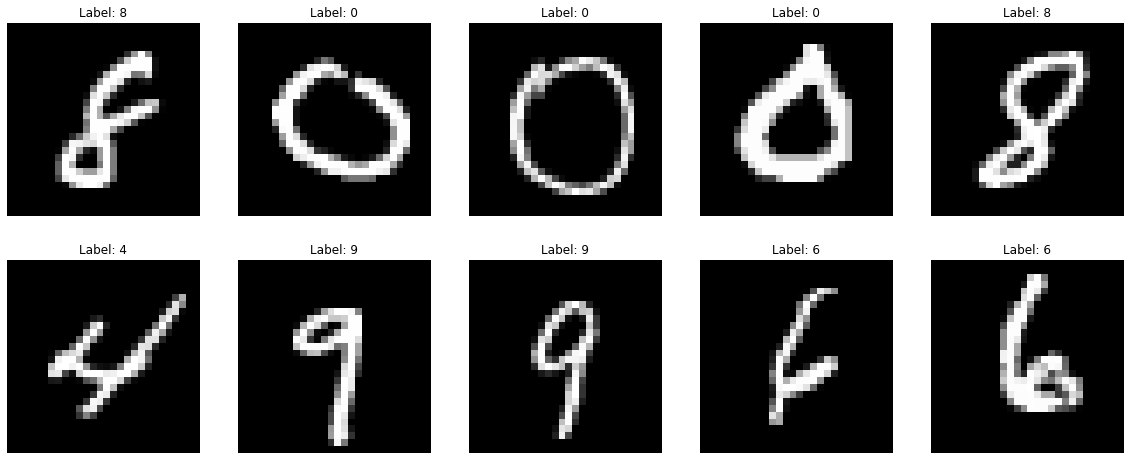

In [52]:
num_samples = 10
rand_samples = np.random.choice(batch_size, num_samples)

batch = next(iter(train_loader))
images, labels = batch

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    image = np.squeeze(images[i].numpy())
    label = labels[i]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Label: {label}")
    ax.axis('off')
    ax.imshow(image, cmap='gray')
plt.show()

### Modelo

In [53]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out

Intanciación del modelo

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Forma de cálculo: {device}')

torch.manual_seed(23)

Forma de cálculo: cuda:0


In [55]:
input_dim = 28 * 28
hidden_dim = 100
output_dim = 10 # 10 Dígitos

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim).to(device)

# Descripción del modelo
summary(model, input_size=(batch_size, 1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
FeedforwardNeuralNetModel                [100, 1, 10]              --
├─Linear: 1-1                            [100, 1, 100]             78,500
├─Sigmoid: 1-2                           [100, 1, 100]             --
├─Linear: 1-3                            [100, 1, 10]              1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 7.95
Input size (MB): 0.31
Forward/backward pass size (MB): 0.09
Params size (MB): 0.32
Estimated Total Size (MB): 0.72

Función de coste

In [56]:
criterion = nn.CrossEntropyLoss()

### Optimizador

In [57]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

### Entrenamiento del modelo

In [58]:
# Info
print(f'Number of epochs: {num_epochs}')
print(f'Batch size: {batch_size}')

Number of epochs: 100
Batch size: 100


In [59]:
epochs = 100 # Número de épocas

losses_train = []
losses_test = []
n_iter = 0

early_stop = True # Early stop
best_test_loss = np.inf
patience = 10
trigger_times = 0

for epoch in tqdm(range(epochs)):
    n_iter = n_iter + 1
    model.train() # Establecer el modo entrenamiento

    # for loop going through dataset
    running_train_loss = 0

    for i, data in enumerate(train_loader):
        x = data[0].to(device).view(-1, 28 * 28).requires_grad_()
        y = data[1].to(device)

        # Borrar los gradientes con respecto a los parámetros
        optimizer.zero_grad()

        # inferencia
        y_hat = model(x)

        # función de coste
        loss = criterion(y_hat, y)

        running_train_loss += loss.item()

        # backward
        loss.backward()
        optimizer.step()
    
    losses_train.append(running_train_loss / len(train_loader))
    
    model.eval()  # Modo evaluation

    ###### Test
    running_test_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            # data preparation
            x = data[0].to(device).view(-1, 28 * 28).requires_grad_()
            y = data[1].to(device)

            y_hat = model(x)

            # función de coste en el conjunto de test
            loss = criterion(y_hat, y)

            running_test_loss += loss.item()

        losses_test.append(running_test_loss / len(test_loader))
        
        if early_stop:
          if running_test_loss >= best_test_loss:
              trigger_times = trigger_times + 1
              if trigger_times >= patience:
                  break
              elif running_test_loss < best_test_loss:
                  best_val_loss = running_test_loss

torch.save(model.state_dict(), './model.cpkt') # Guardar modelo
                

100%|██████████| 100/100 [11:21<00:00,  6.82s/it]


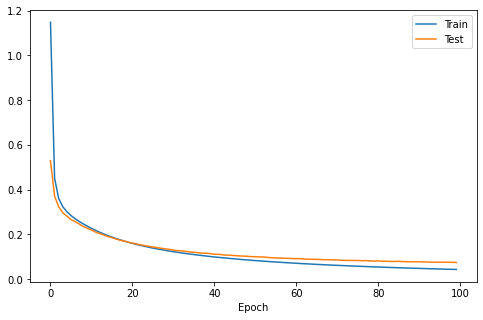

In [60]:
plt.figure(figsize=(8, 5))
plt.plot(losses_train, label='Train')
plt.plot(losses_test, label='Test')
plt.xlabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Cargar el modelo entrenado

In [61]:
model.load_state_dict(torch.load('./model.cpkt'))
model = model.to(device)

### Evaluación del modelo

In [62]:
y_actual = []
y_pred = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        x = data[0].to(device).view(-1, 28 * 28).requires_grad_()
        y = data[1].to(device)

        out = model(x)
        _, y_hat = torch.max(out, 1)

        y_actual = y_actual + list(y.detach().cpu().numpy())
        y_pred = y_pred + list(y_hat.detach().cpu().numpy())

In [63]:
 print(classification_report(y_actual, y_pred, target_names=list(np.unique(y_actual).astype(str))))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

